In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [76]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil
from sklearn.metrics import classification_report

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchsummary import summary
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import torch
# Speeds up convolutions by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Load the data path to images
# Rmb to mount your Gdrive
IMG_DIR = '/content/drive/MyDrive/fish_are_mans_friend/data/train'


# Load the data path to models
MODEL_DIR = '/content/drive/MyDrive/fish_are_mans_friend/models/'

# Batch Size
BATCH_SIZE = 16

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}

# We will assume that all images are of .jpg and .png extensions

In [15]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the training and validation dataset
try:  
  dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
#   dataset = datasets.ImageFolder(IMG_DIR)
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate.
valid_split = 0.2
data_size = len(dataset)
valid_size =  int(data_size * valid_split)
train_size =  data_size - valid_size

train_dataset, valid_dataset = random_split(dataset, [train_size,valid_size],generator=torch.Generator().manual_seed(42))

# # a simple custom collate function, just to show the idea
# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     target = torch.LongTensor(target)
#     return [data, target]


# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True, collate_fn=my_collate)
# valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True, collate_fn=my_collate)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: /content/drive/MyDrive/fish_are_mans_friend/data/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [16]:
# Change the final layer of Model for Transfer Learning
# Here the size of each output sample is set to 8
def augment_model(efficientnet):
    efficientnet.classifier[-1] = nn.Linear(in_features=1792, out_features=len(label_map), bias=True)
    return efficientnet

# Confusion Matrix

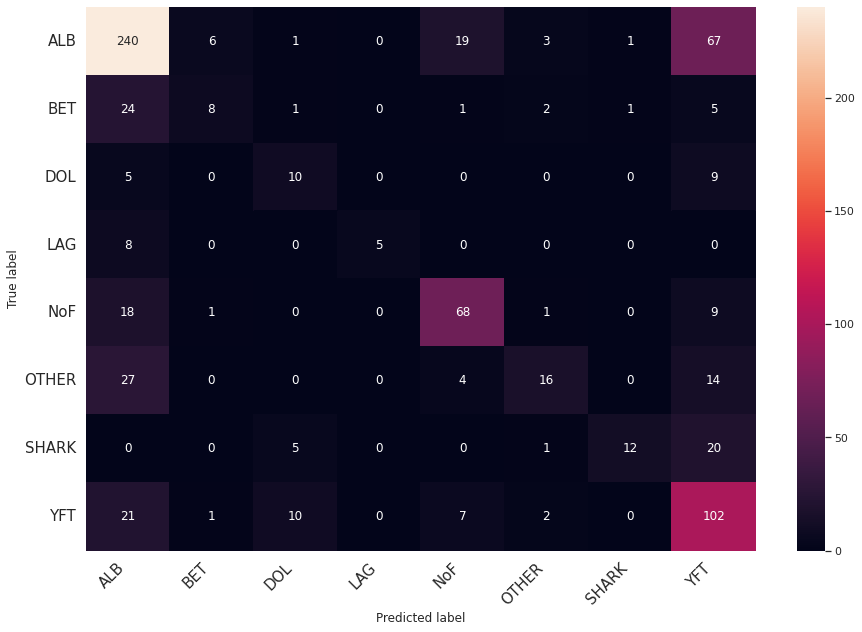

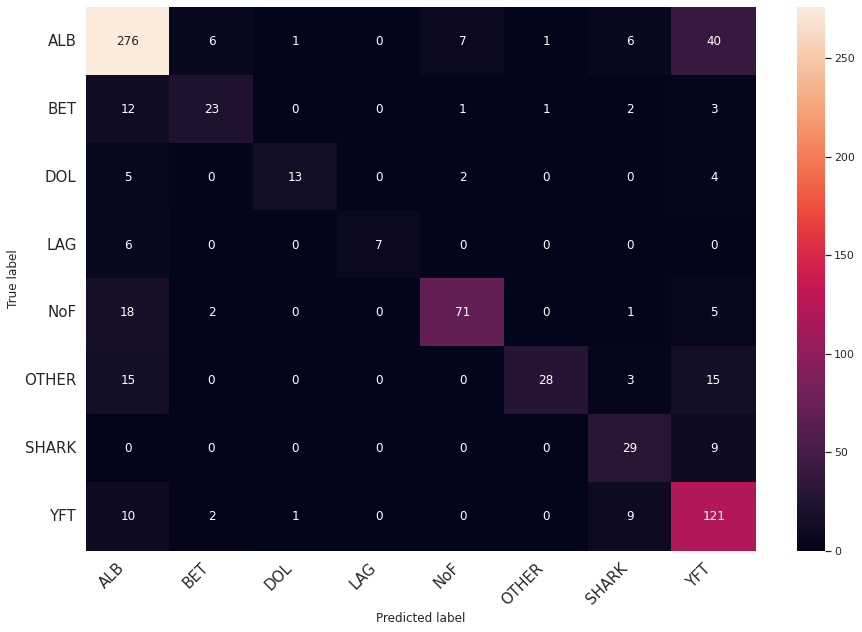

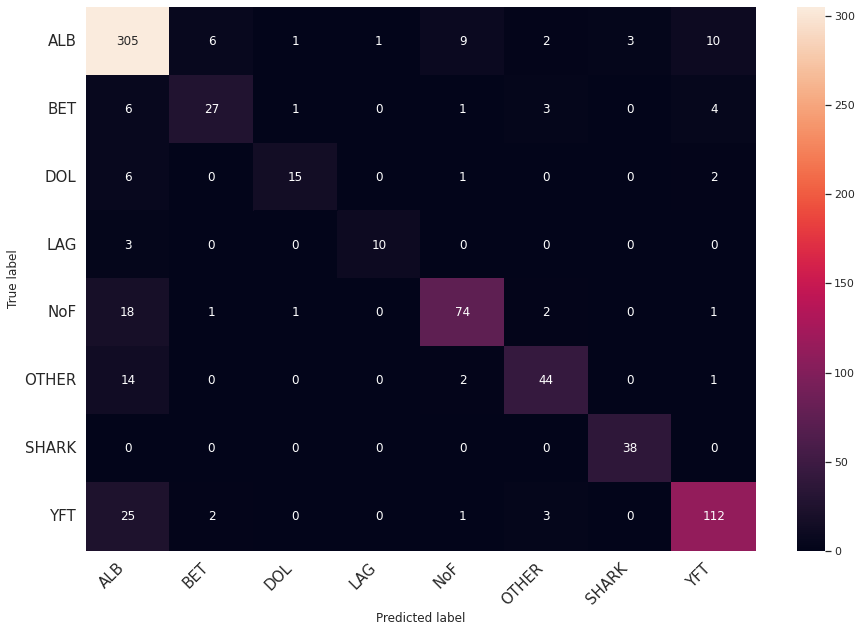

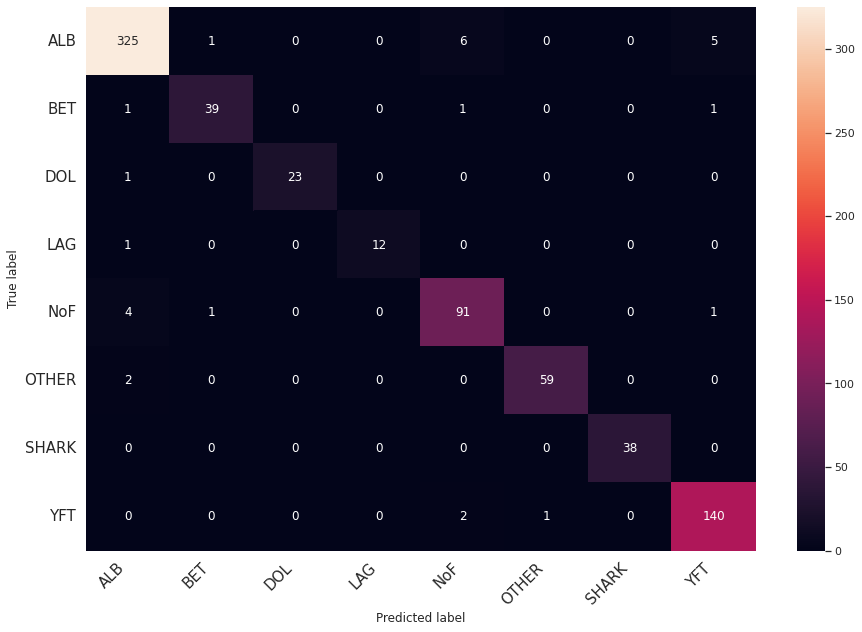

In [19]:
models = ['vgg16','alexnet','resnet','efficientnet']

for model in models:
  if model == 'vgg16':
    model_name = 'VGG16_v3_25_0.672.pt'
  if model == 'alexnet':
    model_name = 'Alexnet_v1_25_0.767.pt'
  if model == 'resnet':
    model_name = 'resnet152_v1_25_0.828.pt'
  if model == 'efficientnet':
    model_name = 'efficientnet_10_25_full.pt'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  path = MODEL_DIR + model_name
  model_ft = torch.load(path,map_location=device)
  model_ft.eval()
  confusion_matrix = torch.zeros(len(label_map), len(label_map))
  pred = []
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(valid_dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)
          pred.append(preds)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  plt.figure(figsize=(15,10))

  class_names = list(label_map.values())
  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


# Classification Report

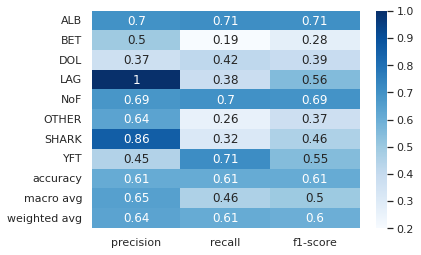

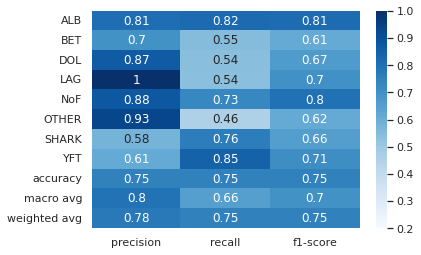

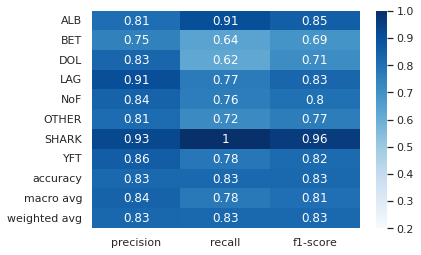

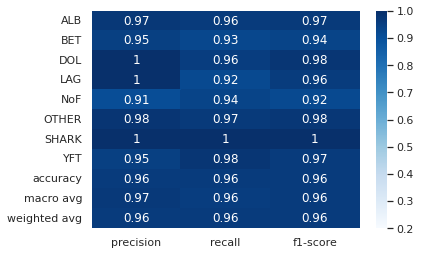

In [ ]:
models = ['vgg16','alexnet','resnet','efficientnet']

for model in models:
  if model == 'vgg16':
    model_name = 'VGG16_v3_25_0.672.pt'
  if model == 'alexnet':
    model_name = 'Alexnet_v1_25_0.767.pt'
  if model == 'resnet':
    model_name = 'resnet152_v1_25_0.828.pt'
  if model == 'efficientnet':
    model_name = 'efficientnet_10_25_full.pt'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  path = MODEL_DIR + model_name
  model_ft = torch.load(path,map_location=device)
  model_ft.eval()
  confusion_matrix = torch.zeros(len(label_map), len(label_map))
  pred = []
  truth = []
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(valid_dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)
          truth.extend(classes.cpu().numpy())
          pred.extend(preds.cpu().numpy())
  clf_report = classification_report(truth,
                                   pred,
                                   target_names=list(label_map.values()),
                                   output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap="Blues", vmin=0.2)
  plt.show()


# Prediction Speed

In [ ]:
models = ['vgg16','alexnet','resnet','efficientnet']
import time
pred_speed = {}
for model in models:
  if model == 'vgg16':
    model_name = 'VGG16_v3_25_0.672.pt'
  if model == 'alexnet':
    model_name = 'Alexnet_v1_25_0.767.pt'
  if model == 'resnet':
    model_name = 'resnet152_v1_25_0.828.pt'
  if model == 'efficientnet':
    model_name = 'efficientnet_10_25_full.pt'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  path = MODEL_DIR + model_name
  model_ft = torch.load(path,map_location=device)
  model_ft.eval()
  confusion_matrix = torch.zeros(len(label_map), len(label_map))
  pred = []
  truth = []
  total_time = 0
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(valid_dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          start = time.time()
          outputs = model_ft(inputs)
          total_time += time.time() - start
          break
  avg_speed = total_time
  pred_speed[model] = avg_speed
print(pred_speed)

{'vgg16': 0.004217624664306641, 'alexnet': 0.003052234649658203, 'resnet': 0.08375430107116699, 'efficientnet': 0.04298067092895508}


# Kaggle submission

In [38]:
models = ['vgg16']
import time
preds = {}
for model in models:
  if model == 'vgg16':
    model_name = 'VGG16_v3_25_0.672.pt'
  if model == 'alexnet':
    model_name = 'Alexnet_v1_25_0.767.pt'
  if model == 'resnet':
    model_name = 'resnet152_v1_25_0.828.pt'
  if model == 'efficientnet':
    model_name = 'efficientnet_10_25_full.pt'
  if model == 'efficientnet2':
    model_name = 'efficientnet_02_full.pt'
  if model == 'efficientnet3':
    model_name = 'efficientnet_03_full.pt'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  path = MODEL_DIR + model_name
  model_ft = torch.load(path,map_location=device)
  model_ft.eval()
  pred = []
  total_time = 0
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(valid_dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          start = time.time()
          outputs = model_ft(inputs)
          normalised_output = torch.nn.functional.softmax(outputs, dim = 1)
          pred.extend(list(normalised_output.cpu().numpy()))
          break
  preds[model] = pred

In [75]:
TEST_DIR = '/content/drive/MyDrive/fish_are_mans_friend/data/nest'
preds = {}
models = ['alexnet','efficientnet','efficientnet3']
counter = 0
for model in models:
  if 'vgg' in model:
          transform = transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
                          )
  else:
    if counter != 0:
          transform = transforms.Compose([
                          transforms.Resize(256),
                          transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]
                          )
          counter = 1
    else:
      pass
  try:  
    test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
  except FileNotFoundError:
    raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 
  
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True,shuffle=False)

  if model == 'vgg16':
    model_name = 'VGG16_v3_25_0.672.pt'
  if model == 'alexnet':
    model_name = 'Alexnet_v1_25_0.767.pt'
  if model == 'resnet':
    model_name = 'resnet152_v1_25_0.828.pt'
  if model == 'efficientnet':
    model_name = 'efficientnet_10_25_full.pt'
  if model == 'efficientnet2':
    model_name = 'efficientnet_02_full.pt'
  if model == 'efficientnet3':
    model_name = 'efficientnet_03_full.pt'

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  path = MODEL_DIR + model_name
  model_ft = torch.load(path,map_location=device)
  model_ft.eval()
  pred = []
  with torch.no_grad():
        for i, (inputs,classes) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            start = time.time()
            outputs = model_ft(inputs)
            normalised_output = torch.nn.functional.softmax(outputs, dim = 1)
            pred.extend(list(normalised_output.cpu().numpy()))
        preds[model] = pred

  np.savetxt('predictions.txt', preds[model])

  print('Begin to write submission file ..')
  f_submit = open(f'submit_{model}.csv', 'w')
  f_submit.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
  for i, image_name in enumerate(glob.glob(TEST_DIR+'/*/*')):
      pred = ['%.6f' % p for p in preds[model][i]]
      if i % 100 == 0:
          print('{} / {}'.format(i, len(glob.glob(TEST_DIR+'/*/*'))))
      f_submit.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))

  f_submit.close()

  print('Submission file successfully generated!')

Begin to write submission file ..
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Submission file successfully generated!
Begin to write submission file ..
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Submission file successfully generated!


KeyboardInterrupt: ignored